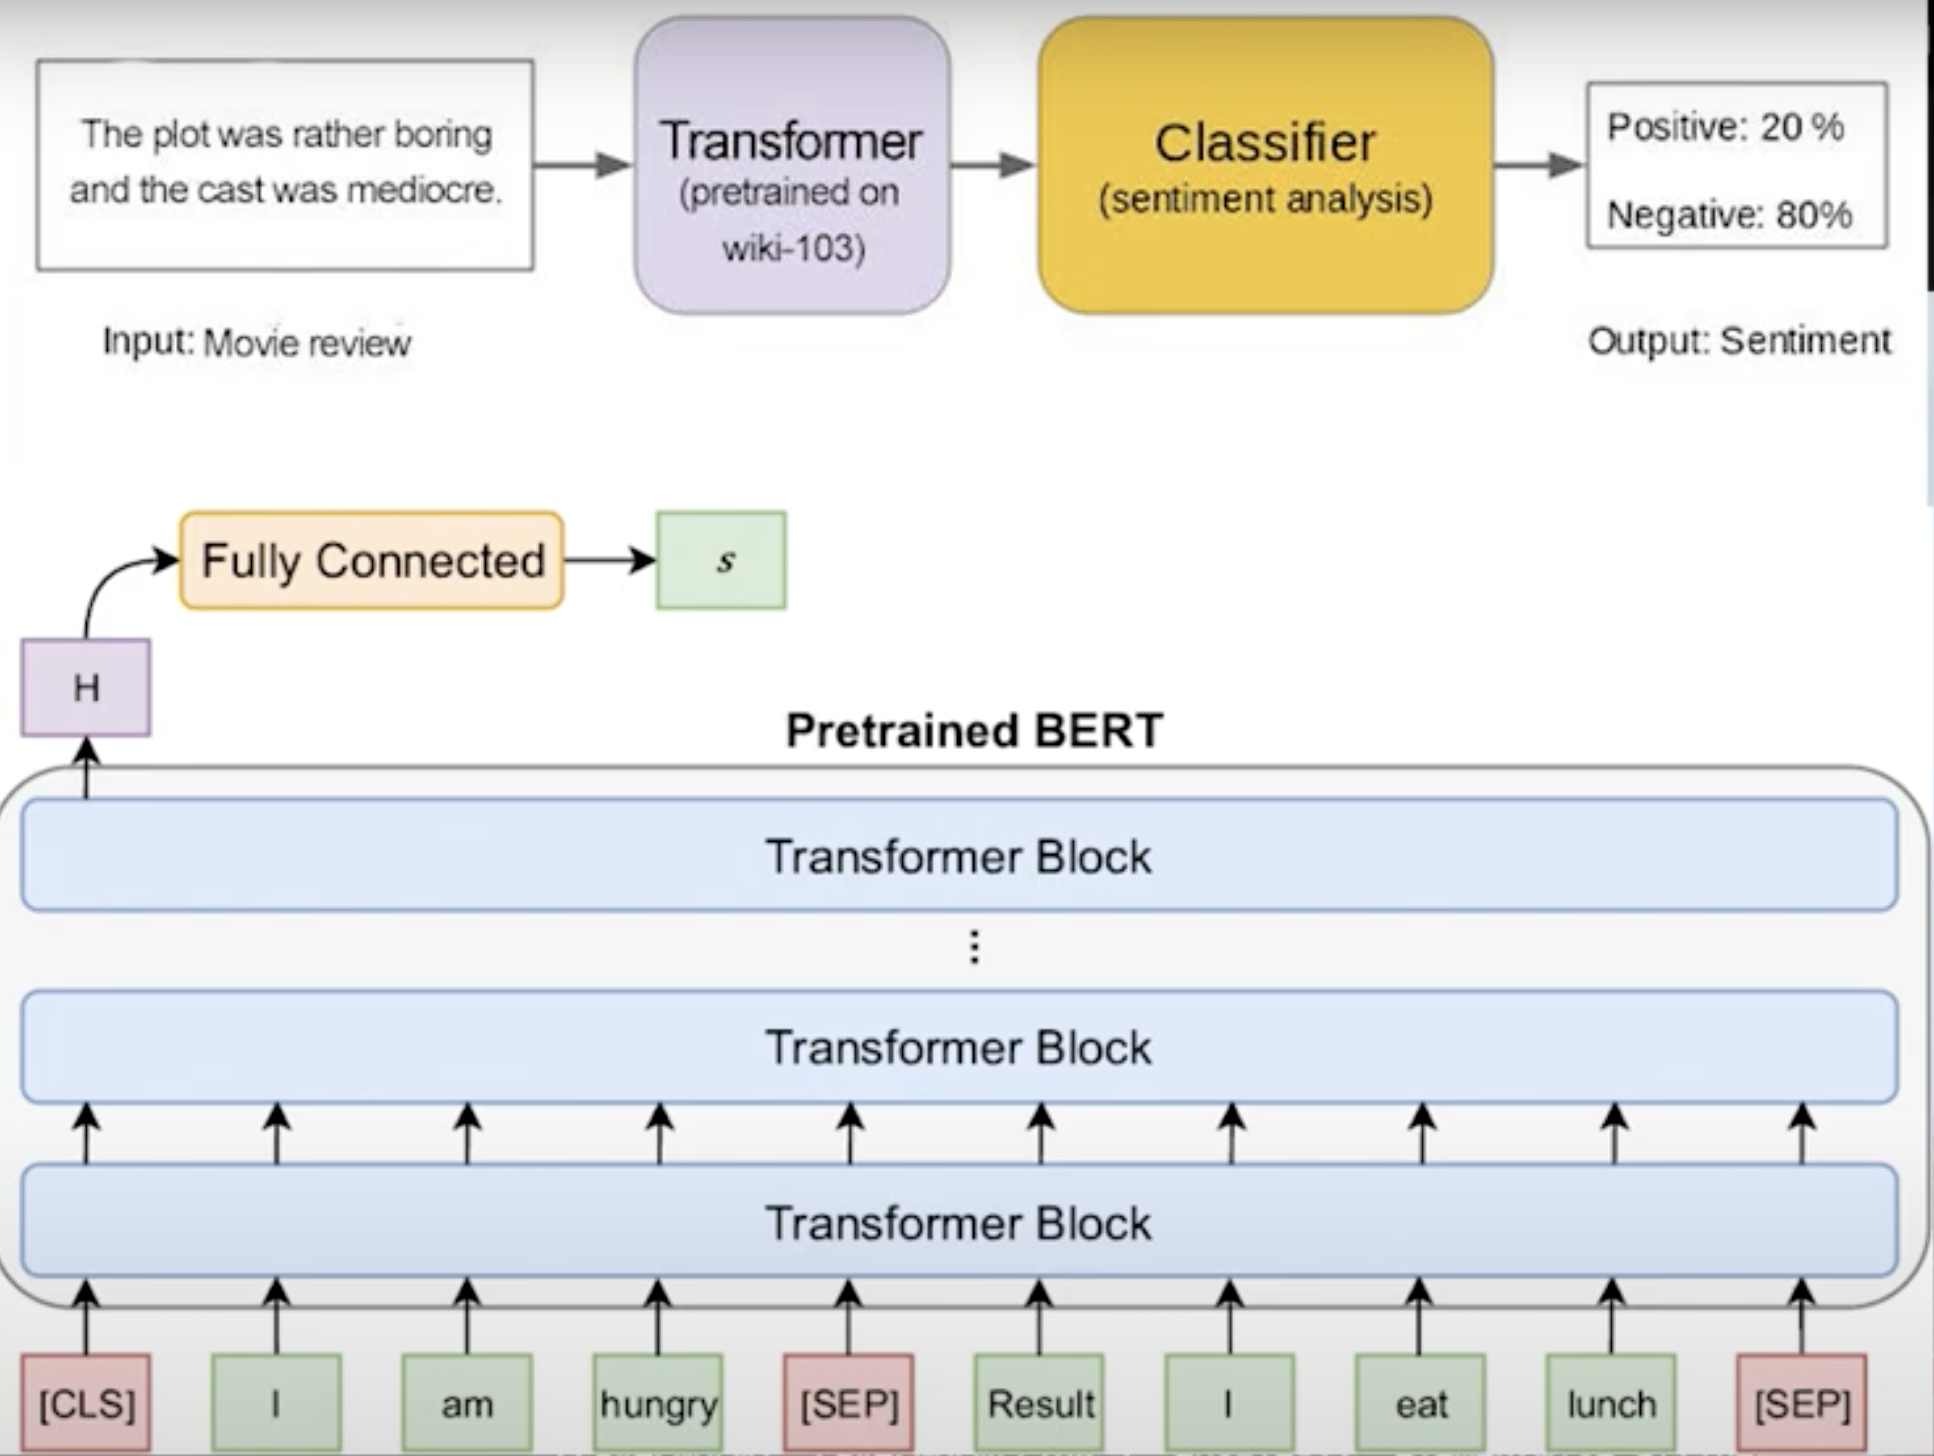

# Flow of raw input text through pretrained BERT 

- The CLS token serves as a special token that is dependent to input sequence and it is designed to be used as an aggregated representation of the entire input sequence for classification task
- first step is tokenization during preprocessing of input sequence
- Tokenizer inserts CLS token at the begginning of the sentence
- tokenized input sequence passed through BERT model embedding layer which converts tokens into continuous valued word vectors
- Encoder layers - self attention and feed forward nn
- During this proccess the model learns to capture semantic and sentatctic info present into input sequence as well as any relationships between input tokens
- final hidden state of CLS will come after this
- At the end of BERT model's encoder layer each token has a corresponding hidden state vector
- For the CLS token its final hidden state is used as an aggreegated representation of the entire input sequence
- This vector is then passed to the task specific classification layer and then the linear layer
- This maps 768 dimensional vector to a vector of size equal to no of classes
- weight matrix mulltipplication folloowed by a bias term addition and then softmax function
- raw op values to claass probabilities
- prediction - class with the highest probability is chosen as a final prediction for the given input sequence
- During task specific fine-tuning, the model leaarrns to adjust weights and biases based on the training data and the target labels.This invvolves updating both BERT model's pretrained parameters and task specific classification layyer's parameters through backprop and optimization techniques
- During the fine-tuning process all of the weights of pretrained BERT model are subject to modification including weights in embedding layer, encoder layers and classification layers. 
- Extend upto these weights modify depends on LR, specific task and training data
- When fine-tuning begins the initial weights come from a pre-trained model whicch has alreday learnt general language representation from large scale unsupervised task ie MLM
- LR is smaller for fine-tuning as compared to pre-training
- FIne-tuning expects a small incremental adjustments to weights to adapt model to specif the task without losing the valuable general language knowledge, the model has acquired during pre-training process


In [1]:
import os
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast, TrainingArguments, Trainer
from torch.utils.data import Dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
ROOT_DIR = "../input/ttc4900"
df = pd.read_csv(os.path.join(ROOT_DIR, '7allV03.csv'))
print(len(df))
df = df.sample(frac=1.0, random_state=42)
print(len(df))
df.head()

4900
4900


,category,text
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...
3539,spor,g saray a git santos van_persie den forma ala...
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...


In [4]:
labels = df['category'].unique().tolist()
labels = [l.strip() for l in labels]
labels

['teknoloji', 'spor', 'dunya', 'kultur', 'ekonomi', 'saglik', 'siyaset']

In [5]:
for key, value in enumerate(labels):
    print(value)

teknoloji
spor
dunya
kultur
ekonomi
saglik
siyaset


In [6]:
NUM_LABELS = len(labels)
label2id = {label:id for id, label in enumerate(labels)}
id2label = {id:label for id, label in enumerate(labels)}

In [7]:
label2id

{'teknoloji': 0,
 'spor': 1,
 'dunya': 2,
 'kultur': 3,
 'ekonomi': 4,
 'saglik': 5,
 'siyaset': 6}

In [8]:
id2label

{0: 'teknoloji',
 1: 'spor',
 2: 'dunya',
 3: 'kultur',
 4: 'ekonomi',
 5: 'saglik',
 6: 'siyaset'}

In [9]:
# Pandas factorize method is used for encoding categorical variables as integers. 
# It assigns a unique integer value to each distinct category in a given Series or DataFrame, 
# effectively transforming non-numeric data into numeric values.

# df['labels_num'] = pd.factorize(df.category)[0]
# df.head()

In [10]:
df['labels'] = df.category.map(lambda x: label2id[x.strip()])
df.head()

,category,text,labels
4657,teknoloji,acıların kedisi sam çatık kaşlı kedi sam in i...,0
3539,spor,g saray a git santos van_persie den forma ala...,1
907,dunya,endonezya da çatışmalar 14 ölü endonezya da i...,2
4353,teknoloji,emniyetten polis logolu virüs uyarısı telefon...,0
3745,spor,beni türk yapın cristian_baroni yıldırım dan ...,1


In [ ]:
df.category.value_counts().plot(kind='pie', figsize=(10,10))

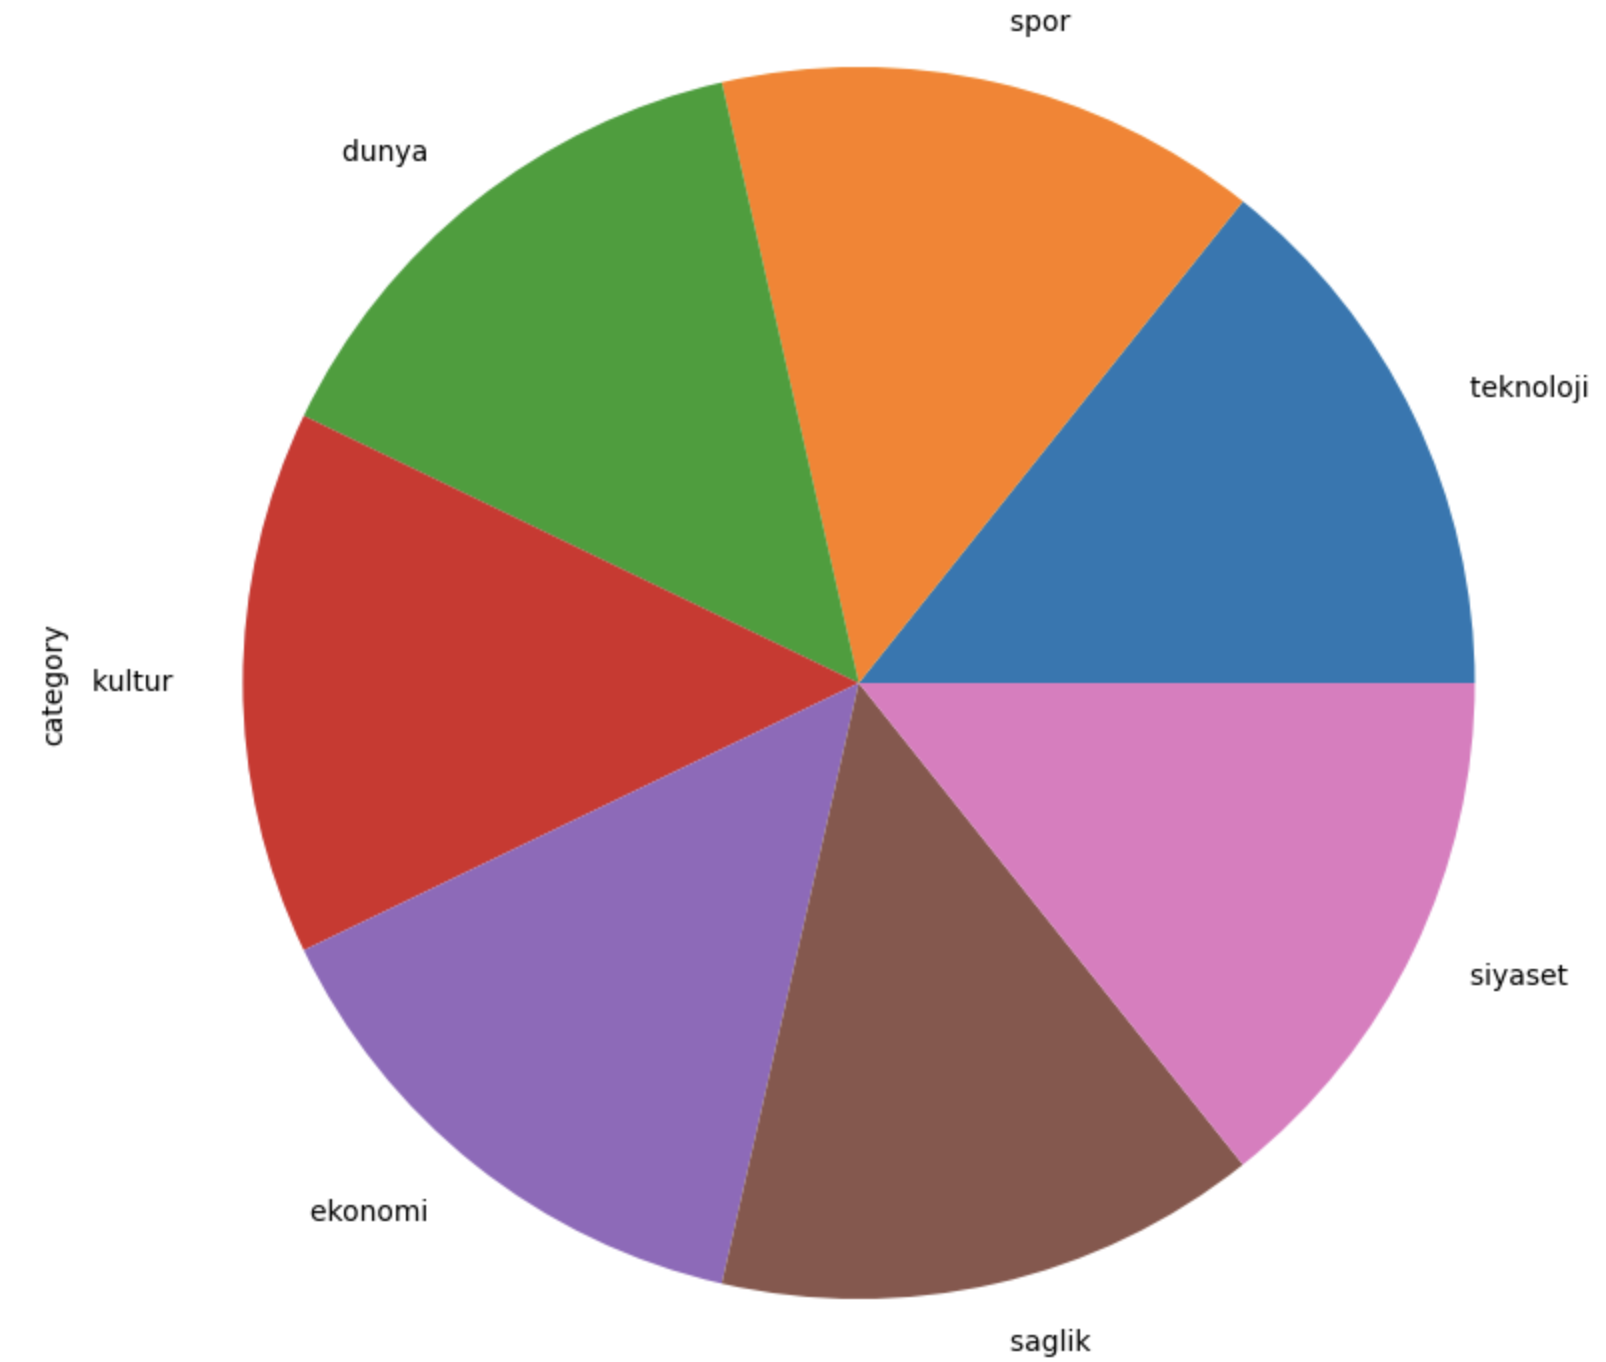

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("dbmdz/bert-base-turkish-uncased", max_length=512)
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-uncased",
    num_labels=NUM_LABELS, 
    id2label=id2label, 
    label2id=label2id
)
model.to(device)

Model components: The model consists of several key components, such as:

Embeddings (word, position, and token type embeddings)

Encoder layers (12 layers in this case, each with self-attention, intermediate, and output components)

Layer normalization and dropout layers for regularization

GELU activation functions used in the intermediate layers

**Model dimensions:**

Word embeddings: The model has an embedding size of 768 dimensions and a vocabulary size of 32,000 tokens.

Position embeddings: The model can handle input sequences of up to 512 tokens in length.

Encoder layers: The model has 12 encoder layers, each with a hidden size of 768 and an intermediate layer size of 3072.

Task-specific classification layer: The BertForSequenceClassification model is designed for sequence classification tasks. It takes the final hidden state of the [CLS] token and passes it through a linear layer and a softmax function to produce class probabilities. In this case, the model is configured with a custom number of labels (NUM_LABELS) and label mappings (id2label, label2id).

In [13]:
SIZE= df.shape[0]

train_texts= list(df.text[:SIZE//2])

val_texts=   list(df.text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df.text[(3*SIZE)//4:])

train_labels= list(df.labels[:SIZE//2])

val_labels=   list(df.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df.labels[(3*SIZE)//4:])

In [14]:
len(train_texts), len(val_texts), len(test_texts)

(2450, 1225, 1225)

In [15]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [16]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

Here's an example of the output format for self.encodings:

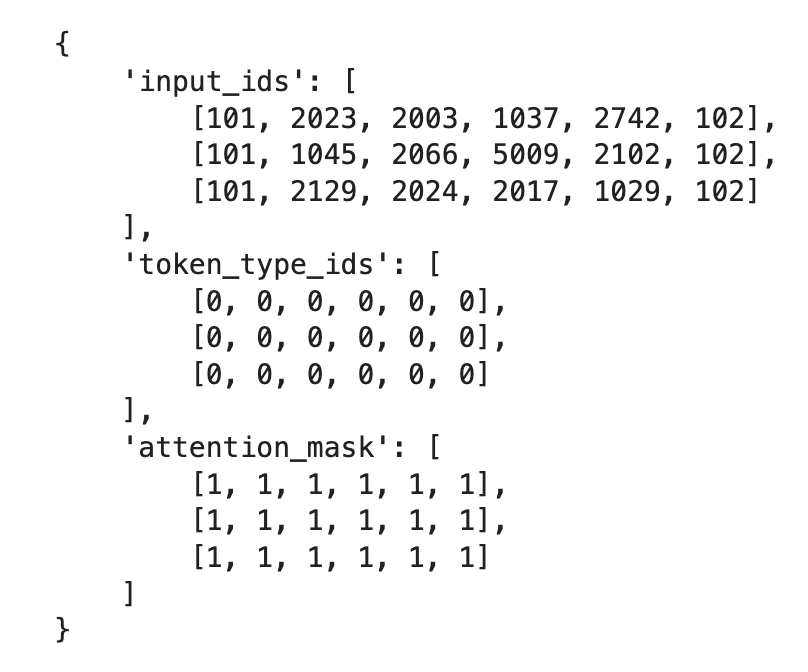

In this example, there are three input sentences, each encoded into three different features: input_ids, token_type_ids, and attention_mask.

input_ids: Lists of token IDs that represent the input text. The integers correspond to the tokens in the tokenizer's vocabulary.

token_type_ids: Lists of token type IDs that indicate the type of each token. In this case, they are all 0 since there is only one sentence per input. In tasks that require sentence pairs, you would see different token type IDs for different sentences.

attention_mask: Lists of binary values that indicate whether a given token should be attended to (1) or not (0). In this example, all tokens are attended to, so all the values are 1. Padding tokens would have a value of 0 in the attention_mask.

In [18]:
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataset = DataLoader(test_encodings, test_labels)

# Training with Trainer class

In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)
    return {
        'Accuracy': accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [20]:
training_args = TrainingArguments(
    output_dir='./TTC4900Model',
    do_train = True,
    do_eval = True,
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 32,
    warmup_steps = 100,
    weight_decay = 0.01,
    logging_strategy = 'steps',
    logging_dir = './multi-class-logs',
    logging_steps = 50,
    evaluation_strategy = 'steps',
    eval_steps = 50,
    save_strategy = 'steps',
    fp16=True,
    load_best_model_at_end = True
)

In [21]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataloader,
    eval_dataset = val_dataloader,
    compute_metrics = compute_metrics
)

In [22]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.830400,1.479226,0.729796,0.727974,0.759618,0.728580
100,0.734200,0.372606,0.892245,0.891041,0.900583,0.893889
150,0.333800,0.379899,0.887347,0.886521,0.893892,0.886212
200,0.221000,0.326725,0.917551,0.917057,0.917013,0.917371
250,0.280200,0.316704,0.918367,0.917104,0.919152,0.919150
300,0.190400,0.284288,0.928163,0.927934,0.928826,0.927482
350,0.121000,0.308245,0.926531,0.925710,0.926079,0.926190
400,0.063500,0.325261,0.922449,0.921868,0.921911,0.922461
450,0.103000,0.317360,0.928980,0.928545,0.928613,0.928665


TrainOutput(global_step=462, training_loss=0.4204238121643727, metrics={'train_runtime': 2363.5201, 'train_samples_per_second': 3.11, 'train_steps_per_second': 0.195, 'total_flos': 1933953073920000.0, 'train_loss': 0.4204238121643727, 'epoch': 3.0})

In [23]:
q = [trainer.evaluate(eval_dataset=df) for df in [train_dataloader, val_dataloader, test_dataset]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.038129,0.990204,0.990165,0.990176,0.990168
val,0.315772,0.929796,0.929346,0.929294,0.929508
test,0.296865,0.926531,0.925854,0.926105,0.925663


In [24]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt').to('cuda')
    outputs = model(**inputs)
    probs = outputs[0].softmax(1)
    
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]
    
    return probs, pred_label_idx, pred_label

In [25]:
# Test with a an example text in Turkish
text = "Makine öğrenimi kendisi de daha da otomatik hale doğru ilerliyor."
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.9636, 0.0023, 0.0062, 0.0043, 0.0129, 0.0075, 0.0031]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(0, device='cuda:0'),
 'teknoloji')

In [26]:
model_path = "turkish-text-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('turkish-text-classification-model/tokenizer_config.json',
 'turkish-text-classification-model/special_tokens_map.json',
 'turkish-text-classification-model/vocab.txt',
 'turkish-text-classification-model/added_tokens.json',
 'turkish-text-classification-model/tokenizer.json')

In [27]:
model_path = "turkish-text-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [28]:
nlp("Bugün hava çok güzel, dışarıda yürümek istiyorum.")
# Today the weather is very nice, I want to go for a walk outside

# Gives below output
#[{'label': 'saglik', 'score': 0.8295329213142395}]
# "Saglik" is a Turkish word that means "health" in English.

[{'label': 'saglik', 'score': 0.5222746729850769}]

In [29]:
nlp("Derin Öğrenme ve Yapay Zeka dünyayı değiştirecek.")
# Deep Learning and AI is going to change the world

# gives below output
#[{'label': 'teknoloji', 'score': 0.9932782053947449}]

[{'label': 'teknoloji', 'score': 0.9929021000862122}]

In [30]:
nlp("Son zamanlarda ekonomideki oynaklık nedeniyle, borsa endeksi oldukça düşük seviyelerde seyrediyor.")
# Due to recent volatility in the economy, the stock market index has been at quite low levels

#gives below output
#[{'label': 'ekonomi', 'score': 0.9850727915763855}]

[{'label': 'ekonomi', 'score': 0.9944878220558167}]